## Load libraries

In [64]:
#from google.colab import drive
#drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
#!pwd

/content


In [ ]:
#!pip freeze

In [ ]:
#!pip uninstall scipy
#!pip install scipy==1.10.0

In [2]:
# kaggle.com/code/jesucristo/1-house-prices-solution-top-1

import numpy as np
import pandas as pd

from datetime import datetime
from scipy.stats import skew
from scipy.special import boxcox1p    # box-cox transformation
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
#import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
import pickle

import os
import pprint
import math

In [69]:
print('test')
!pwd

test
/content


## Load data

In [3]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
# train = pd.read_csv("/content/drive/MyDrive/competitions/data/train.csv")
# test = pd.read_csv("/content/drive/MyDrive/competitions/data/test.csv")

In [4]:
pprint.pprint(train.head())
print("="*30)
print(train.shape)
print("="*30)
print(train.info())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

In [ ]:
pprint.pprint(test.head())
print("="*30)
print(test.shape)
print("="*30)
print(test.info())

## Engeneering data analysis

In [5]:
quantitative = [f for f in train.columns if train.dtypes[f] != object]
quantitative.remove('Id')
quantitative.remove('SalePrice')
print(quantitative)
print(len(quantitative))

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
36


In [6]:
qualitative = [f for f in train if train.dtypes[f] == object]

print(qualitative)
print(len(qualitative))

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
43


### Check how many data is missing

<Axes: >

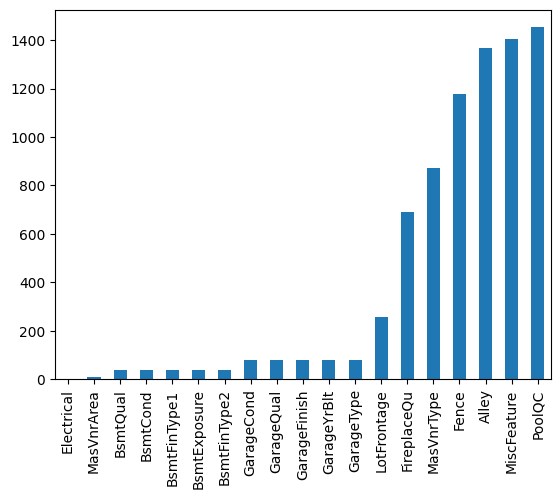

In [7]:
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

### Analysis empirical PDF of SalePrice (no seaborn)

In [8]:
y = train['SalePrice']
x_tmp = y.sort_values(inplace=False)

In [9]:
def n_bins_danoes_formula(data):
    """
    # Doane's formula (hist of nonnormal data)
    data - for example y data

    # stackoverflow Fitting empirical distribution to theoretical ones with Scipy
    """

    N = len(data)
    skewness = stats.skew(data)

    # estimated 3th moment of distribution
    sigma_g1 = math.sqrt((6 * (N - 2))/((N + 1) * (N + 3)))
    num_bins = round(1 + math.log(N, 2) + math.log(1 + abs(skewness)/sigma_g1, 2))
    return num_bins

if __name__ == "__main__":
    print(n_bins_danoes_formula(y))


16


In [10]:
def plot_histogram(data, res, n):

    # n - first distributions of the ranking
    N_DISTRIBUTION = {k: res[k] for k in list(res)[:n]}

    # hist of data
    fig, ax = plt.subplots()
    ax.hist(data, density=True)
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequencises')

    # plot empirical distributions
    for distribution, res in N_DISTRIBUTION.items():

        sse = res[0]
        arg = res[1]
        loc = res[2]
        scale = res[3]
        x_plot = np.linspace(min(data), max(data), 1000)
        y_plot = distribution.pdf(x_plot, loc=loc, scale=scale, *arg)
        ax.plot(x_plot, y_plot, label=str(distribution)[32:41] + ":" + str(sse)[0:6])

    ax.legend(title='Distributions', loc='upper left')
    ax.grid()
    plt.show()


In [11]:
def fit_data(data, my_distributions):

    """
    """

    all_distributions = [
               stats.alpha,             # 0 Alpha
               stats.anglit,            # 1 Anglit
               stats.arcsine,           # 2 Arcsine
               stats.argus,             # 3 Argus
               stats.beta,              # 4 Beta
               stats.betaprime,         # 5 Beta Prime
               stats.bradford,          # 6 Bradford
               stats.burr,              # 7 Burr (Type III)
               stats.burr12,            # 8 Burr (Type XII)
               stats.cauchy,            # 9 Cauchy
               stats.chi,               # 10 Chi
               stats.chi2,              # 11 Chi-squared
               stats.cosine,            # 12 Cosine
               stats.crystalball,       # 13 Crystalball
               stats.dgamma,            # 14 Double Gamma
               stats.dweibull,          # 15 Double Weibull
               stats.erlang,            # 16 Erlang
               stats.expon,             # 17 Exponential
               stats.exponnorm,         # 18 Exponentially Modified Normal
               stats.exponweib,         # 19 Exponentiated Weibull
               stats.exponpow,          # 20 Exponential Power
               stats.f,                 # 21 F (Snecdor F)
               stats.fatiguelife,       # 22 Fatigue Life (Birnbaum-Saunders)
               stats.fisk,              # 23 Fisk
               stats.foldcauchy,        # 24 Folded Cauchy
               stats.foldnorm,          # 25 Folded Normal
               stats.genlogistic,      # 26 Generalized Logistic
               stats.gennorm,           # 27 Generalized normal
               stats.genpareto,         # 28 Generalized Pareto
               stats.genexpon,          # 29 Generalized Exponential
               stats.genextreme,        # 30 Generalized Extreme Value
               stats.gausshyper,        # 31 Gauss Hypergeometric
               stats.gamma,             # 32 Gamma
               stats.gengamma,          # 33 Generalized gamma
               stats.genhalflogistic,   # 34 Generalized Half Logistic
               stats.genhyperbolic,     # 35 Generalized Hyperbolic
               stats.geninvgauss,       # 36 Generalized Inverse Gaussian
               stats.gibrat,            # 37 Gibrat
               #stats.gilbrat,           # 38 Gilbrat
               stats.gompertz,          # 39 Gompertz (Truncated Gumbel)
               stats.gumbel_r,          # 40 Right Sided Gumbel, Log-Weibull, Fisher-Tippett, Extreme Value Type I
               stats.gumbel_l,          # 41 Left Sided Gumbel, etc.
               stats.halfcauchy,        # 42 Half Cauchy
               stats.halflogistic,      # 43 Half Logistic
               stats.halfnorm,          # 44 Half Normal
               stats.halfgennorm,       # 45 Generalized Half Normal
               stats.hypsecant,         # 46 Hyperbolic Secant
               stats.invgamma,          # 47 Inverse Gamma
               stats.invgauss,          # 48 Inverse Gaussian
               stats.invweibull,        # 49 Inverse Weibull
               stats.johnsonsb,         # 50 Johnson SB
               stats.johnsonsu,         # 51 Johnson SU
               stats.kappa4,            # 52 Kappa 4 parameter
               stats.kappa3,            # 53 Kappa 3 parameter
               stats.ksone,             # 54 Distribution of Kolmogorov-Smirnov one-sided test statistic
               stats.kstwo,             # 55 Distribution of Kolmogorov-Smirnov two-sided test statistic
               stats.kstwobign,         # 56 Limiting Distribution of scaled Kolmogorov-Smirnov two-sided test statistic.
               stats.laplace,           # 57 Laplace
               stats.laplace_asymmetric,    # 58 Asymmetric Laplace
               stats.levy,              # 59 Levy
               stats.levy_l,            # 60
               stats.levy_stable,       # 61
               stats.logistic,          # 62 Logistic
               stats.loggamma,          # 63 Log-Gamma
               stats.loglaplace,        # 64 Log-Laplace (Log Double Exponential)
               stats.lognorm,           # 65 Log-Normal
               stats.loguniform,        # 66 Log-Uniform
               stats.lomax,             # 67 Lomax (Pareto of the second kind)
               stats.maxwell,           # 68 Maxwell
               stats.mielke,            # 69 Mielke's Beta-Kappa
               stats.moyal,             # 70 Moyal
               stats.nakagami,          # 71 Nakagami
               stats.ncx2,              # 72 Non-central chi-squared
               stats.ncf,               # 73 Non-central F
               stats.nct,               # 74 Non-central Student's T
               stats.norm,              # 75 Normal (Gaussian)
               stats.norminvgauss,      # 76 Normal Inverse Gaussian
               stats.pareto,            # 77 Pareto
               stats.pearson3,          # 78 Pearson type III
               stats.powerlaw,          # 79 Power-function
               stats.powerlognorm,      # 80 Power log normal
               stats.powernorm,         # 81 Power normal
               stats.rdist,             # 82 R-distribution
               stats.rayleigh,          # 83 Rayleigh
               stats.rice,              # 84 Rice
               stats.recipinvgauss,     # 85 Reciprocal Inverse Gaussian
               stats.semicircular,      # 86 Semicircular
               stats.skewcauchy,        # 87 Skew Cauchy
               stats.skewnorm,          # 88 Skew normal
               stats.studentized_range,    # 89 Studentized Range
               stats.t,                 # 90 Student's T
               stats.trapezoid,         # 91 Trapezoidal
               stats.triang,            # 92 Triangular
               stats.truncexpon,        # 93 Truncated Exponential
               stats.truncnorm,         # 94 Truncated Normal
               stats.truncpareto,       # 95 Truncated Pareto
               stats.truncweibull_min,  # 96 Truncated minimum Weibull distribution
               stats.tukeylambda,       # 97 Tukey-Lambda
               stats.uniform,           # 98 Uniform
               stats.vonmises,          # 99 Von-Mises (Circular)
               stats.vonmises_line,     # 100 Von-Mises (Line)
               stats.wald,              # 101 Wald
               stats.weibull_min,       # 102 Minimum Weibull (see Frechet)
               stats.weibull_max,       # 103 Maximum Weibull (see Frechet)
               stats.wrapcauchy         # 104 Wrapped Cauchy
        ]

    #my_distributions = [all_distributions[51], all_distributions[73], all_distributions[63]]
    my_distributions = [all_distributions[i] for i in my_distributions]
    pprint.pprint(my_distributions)

    # estimate histogram
    num_bins = n_bins_danoes_formula(data)
    frequencies, bin_edges = np.histogram(data, num_bins, density=True)
    central_values = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges) - 1)]

    results = {}
    for distribution in my_distributions:

        # get parameters of distribution
        params = distribution.fit(data)

        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # calculate fitted PDF and error with fit in distibution
        pdf_values = [distribution.pdf(c, loc=loc, scale=scale, *arg) for c in central_values]

        # calculate sum of squert estimate of errors
        sse = np.sum(np.power(frequencies - pdf_values, 2.0))

        # calculate results and sort by sse
        results[distribution] = [sse, arg, loc, scale]

    results = {k: results[k] for k in sorted(results, key=results.get)}
    return results


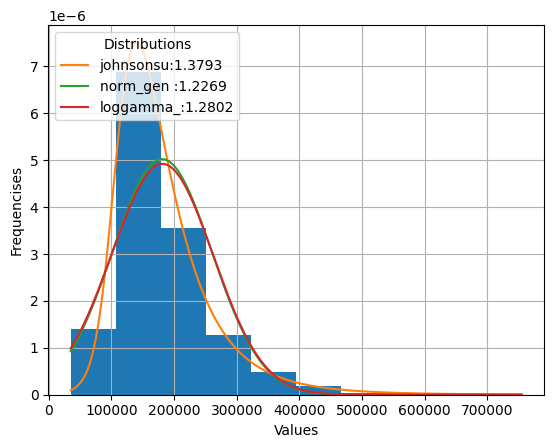

In [12]:
my_distributions = [50, 74, 62]

results = fit_data(y, my_distributions)
plot_histogram(y, results, 5)

## Conlusions:
 - SalePrice variable is not normal distributed
 - it has to be transformed
 - best fitted is Johnson distribution

## Perform the Shapiro-Wilk tests for normality of quantitive variables

In [13]:
normal = pd.DataFrame(train[quantitative])

#test_normality_shapiro = lambda x: stats.shapiro(x.dropna())[1] < 0.01
test_normality_shapiro = lambda x: stats.shapiro(x.fillna(0))[1]
normal_shapiro = normal.apply(test_normality_shapiro)
print(not normal_shapiro.any())

False


In [ ]:
print(stats.__doc__)

## Conlusion:
- none of quantitative variable has got normal distribustion

## Spearman corelation

In [15]:
def encode(frame, feature):

    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()

    # create index as feature
    ordering.index = ordering.val

    # means of 'SalePrice' in each group of feature
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']

    # sorting, condition is mean of SalePrice
    ordering = ordering.sort_values('spmean')

    # create new column with position of sorted values
    ordering['ordering'] = range(1, ordering.shape[0] + 1)
    ordering = ordering['ordering'].to_dict()

    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature + '_E'] = o

qual_encoded = []

for q in qualitative:
    encode(train, q)
    qual_encoded.append(q + '_E')

print(qual_encoded)


['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


In [16]:
def correlation(frame, features, method):
    """
    method = {'pearson', 'spearman' }

    """

    spr = pd.DataFrame()
    spr['feature'] = features

    # compute method of spearman correlation between two series
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], method=method) for f in features]
    spr = spr.sort_values('spearman')
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 3)
    ax.bar(spr['feature'], spr['spearman'])
    ax.tick_params(axis='x', labelrotation=90)
    #ax.set_xticklabels(ax.get_xticks(), rotation=90)

    plt.show()
    pprint.pprint(spr['feature'])


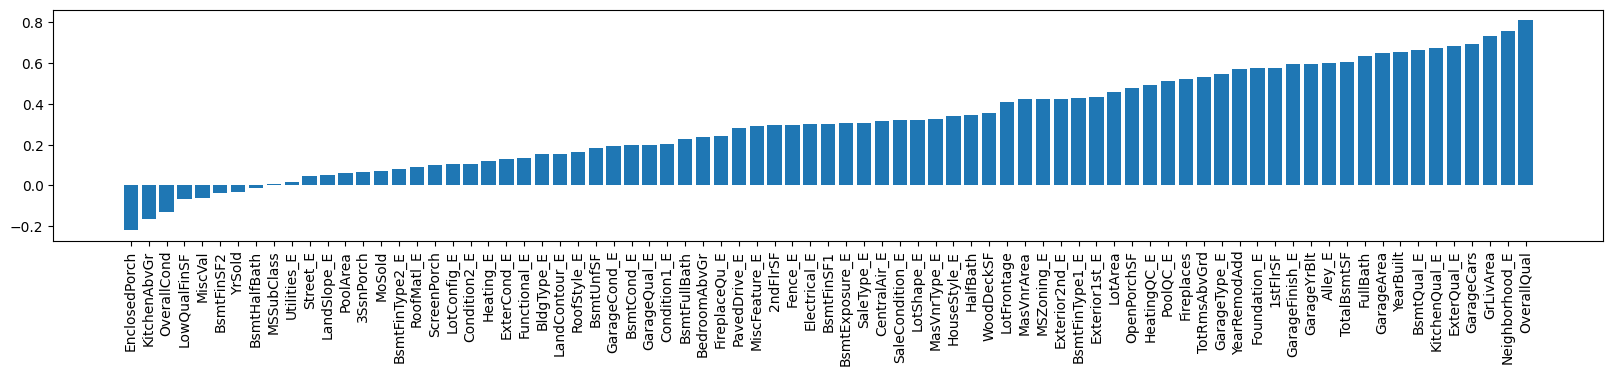

29     EnclosedPorch
21      KitchenAbvGr
4        OverallCond
14      LowQualFinSF
33           MiscVal
           ...      
54       ExterQual_E
25        GarageCars
15         GrLivArea
44    Neighborhood_E
3        OverallQual
Name: feature, Length: 79, dtype: object


In [17]:
features = quantitative + qual_encoded
correlation(train, features, method='spearman')

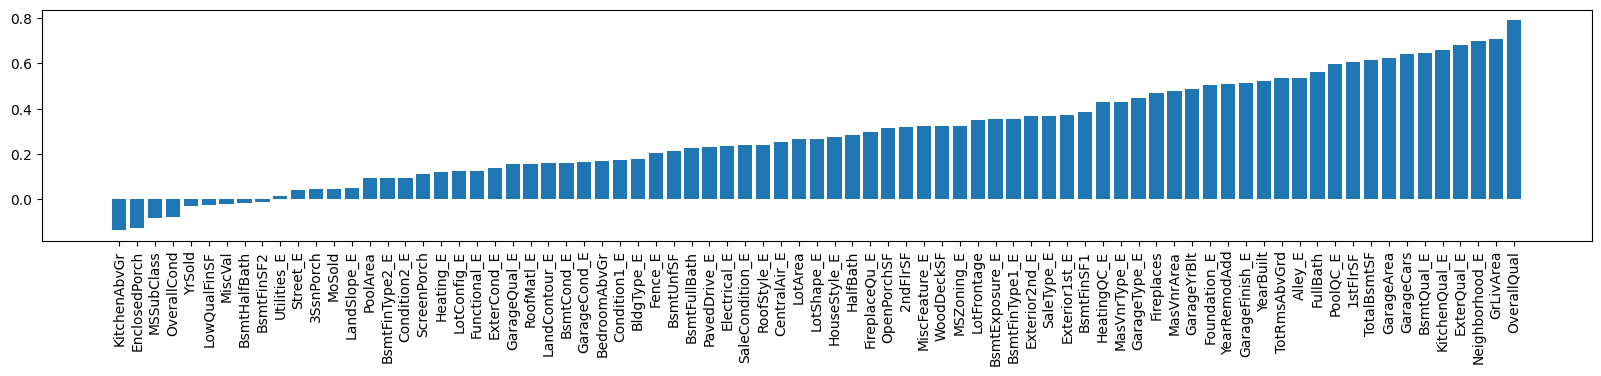

21      KitchenAbvGr
29     EnclosedPorch
0         MSSubClass
4        OverallCond
35            YrSold
           ...      
66     KitchenQual_E
54       ExterQual_E
44    Neighborhood_E
15         GrLivArea
3        OverallQual
Name: feature, Length: 79, dtype: object


In [23]:
correlation(train, features, method='pearson')

## Conclusions:
- Spearman correlation is better hier, becouse it picks up relationships between variables even when they ara nonlinear
- OverallQual is main criterion in establishing house price

## Corellation between features

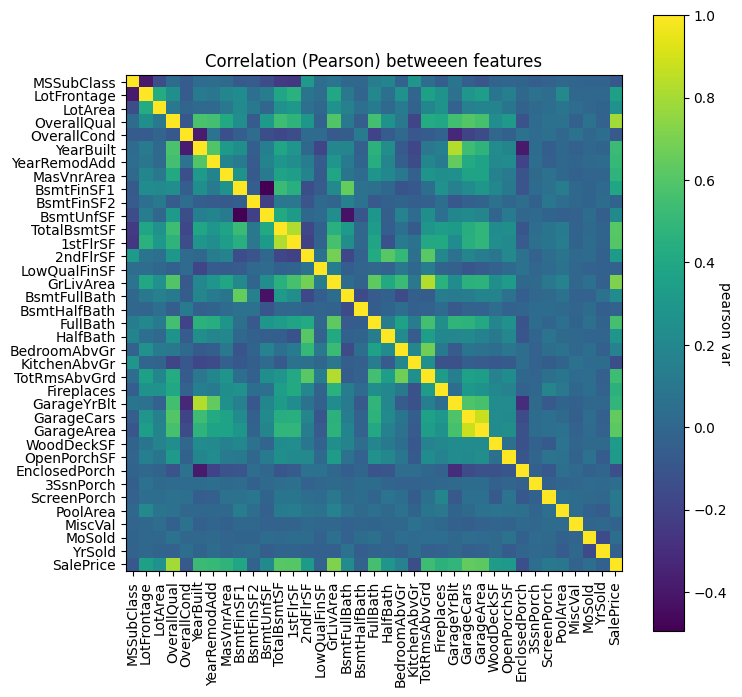

In [18]:
corr = train[quantitative + ['SalePrice']].corr()
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
im = ax.imshow(corr)
ax.set_title("Correlation (Pearson) betweeen features")
ax.set_xticks(list(range(0, len(list(train[quantitative + ['SalePrice']].columns)))),
              list(train[quantitative + ['SalePrice']].columns))
ax.tick_params(axis='x', labelrotation=90)
ax.set_yticks(list(range(0, len(list(train[quantitative + ['SalePrice']].columns)))),
              list(train[quantitative + ['SalePrice']].columns))
ax.spines[:].set_visible(True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("pearson var", rotation=-90)
plt.show()

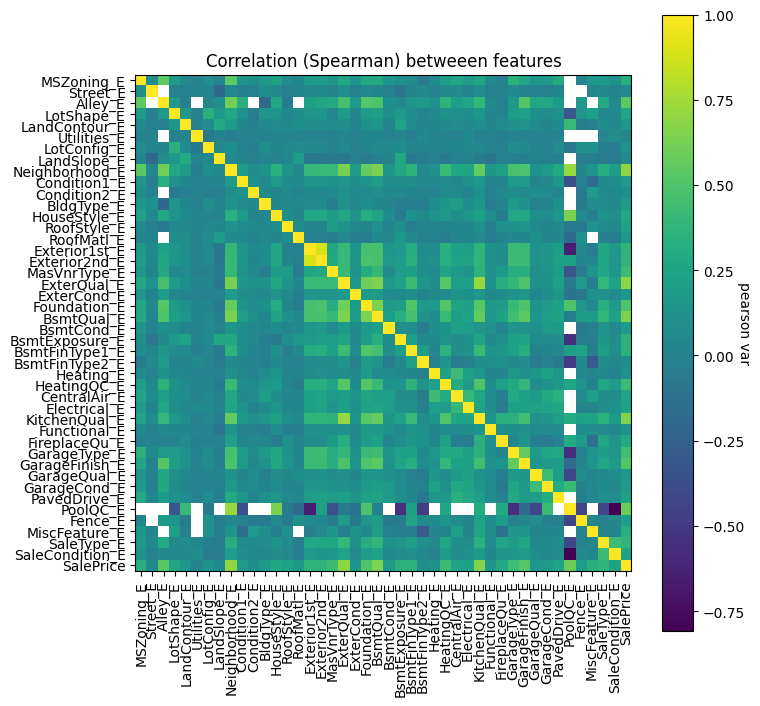

In [25]:
corr = train[qual_encoded + ['SalePrice']].corr()
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
im = ax.imshow(corr)
ax.set_title("Correlation (Spearman) betweeen features")
ax.set_xticks(list(range(0, len(list(train[qual_encoded + ['SalePrice']].columns)))),
              list(train[qual_encoded + ['SalePrice']].columns))
ax.tick_params(axis='x', labelrotation=90)
ax.set_yticks(list(range(0, len(list(train[qual_encoded + ['SalePrice']].columns)))),
              list(train[qual_encoded + ['SalePrice']].columns))
ax.spines[:].set_visible(True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("pearson var", rotation=-90)
plt.show()

## Use T - distributed Stochastic Neighbor Embeding (t-SNE) to visualize similarities between data points

In [19]:
features = quantitative + qual_encoded
model = TSNE(n_components=2, random_state=42, perplexity=50)
X = train[features].fillna(0).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)

pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)

kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0],
                  'tsne2': tsne[:,1],
                  'cluster': kmeans.labels_})

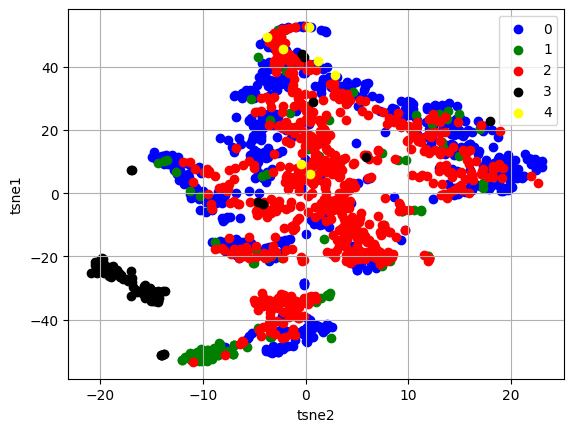

In [20]:
fr.sort_values(by='cluster', inplace=True)

values = fr.cluster.unique()
colors = ['blue', 'green', 'red', 'black', 'yellow']

fig, ax = plt.subplots()
for i in zip(values, colors):
    ax.scatter(fr[fr.cluster == i[0]].iloc[:, 1], fr[fr.cluster == i[0]].iloc[:, 0], color=i[1], label=i[0])

ax.legend()
ax.set_xlabel('tsne2')
ax.set_ylabel('tsne1')
ax.grid()
plt.show()

## Engeneering Data Analysis

In [28]:
type(test)

pandas.core.frame.DataFrame

In [21]:
#train = pd.read_csv("data/train.csv")
#test = pd.read_csv("data/test.csv")

train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

# take GrLivArea only below 4500 m
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)

# take log + 1 of continue labels
train['SalePrice'] = np.log1p(train['SalePrice'])
y = train['SalePrice'].reset_index(drop=True)

In [22]:
# remove continue labels from data
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# concatenate train and test data
features = pd.concat([train_features, test_features]).reset_index(drop=True)

In [23]:
features.shape
features.head(4)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,SaleType_E,SaleCondition_E
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,2.0,1.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,2.0


In [24]:
features['MSSubClass'] = features['MSSubClass'].apply(str) # Identifies the type of dwelling involved in the sale.
features['YrSold'] = features['YrSold'].astype(str)  # year sold
features['MoSold'] = features['MoSold'].astype(str)  # month Sold
features['Functional'] = features['Functional'].fillna('Typ') # home functionality 'Typ' - typical
features['Electrical'] = features['Electrical'].fillna("SBrkr")  # electrical SBrkr	-
                                                                 # Standard Circuit Breakers & Romex
features['KitchenQual'] = features['KitchenQual'].fillna("TA")   # Kitchen quality TA - typical/average
features["PoolQC"] = features["PoolQC"].fillna("None")  # Pool quality
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) # Exterior covering
                                                                                            # on house - mode - most
                                                                                            # common value (str)
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0]) # Type of sale

In [25]:
features.shape

(2917, 122)

In [26]:
# fill with 0 cells: 'GarageYrBlt', 'GarageArea', 'GarageCars'
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)

# fill with None cells: 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')

# fill with None cels: BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

# fill with mode (most common value) in MSZoning grouping by MSSubClass
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [27]:
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))

features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

In [28]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

pt = PowerTransformer()

# for i in skew_index:
#     features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

for i in skew_index:
    features[i] = pt.fit_transform(np.array(features[i]).reshape(-1, 1))


In [29]:
features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])


In [30]:
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [31]:
print(features.shape)
print(features.head(4))

(2917, 129)
  MSSubClass MSZoning  LotFrontage   LotArea Alley LotShape LandContour  \
0         60       RL    -0.155979 -0.137283  None      Reg         Lvl   
1         20       RL     0.542160  0.116745  None      Reg         Lvl   
2         60       RL    -0.012027  0.438787  None      IR1         Lvl   
3         70       RL    -0.401375  0.106261  None      IR1         Lvl   

  LotConfig LandSlope Neighborhood  ... YrBltAndRemod   TotalSF  \
0    Inside       Gtl      CollgCr  ...          4006  0.011338   
1       FR2       Gtl      Veenker  ...          3952  0.093618   
2    Inside       Gtl      CollgCr  ...          4003  0.390300   
3    Corner       Gtl      Crawfor  ...          3885  0.110638   

  Total_sqr_footage Total_Bathrooms  Total_porch_sf  haspool  has2ndfloor  \
0          0.845994        3.689986       -0.975512        0            1   
1          0.221205        2.754575       -0.717950        0            0   
2          0.848596        3.689986       -1.

In [32]:
final_features = pd.get_dummies(features).reset_index(drop=True)
print(final_features.shape)
print(final_features.head(4))

(2917, 376)
   LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0    -0.155979 -0.137283            7    -0.480390       2003          2003   
1     0.542160  0.116745            6     2.072649       1976          1976   
2    -0.012027  0.438787            7    -0.480390       2001          2002   
3    -0.401375  0.106261            7    -0.480390       1915          1970   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  SaleType_ConLw  \
0    1.253043    0.805851   -0.367447  -0.869118  ...           False   
1   -0.804654    1.019279   -0.367447  -0.415928  ...           False   
2    1.218147    0.579989   -0.367447  -0.030323  ...           False   
3   -0.804654    0.151012   -0.367447   0.200425  ...           False   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0         False         False         True                  False   
1         False         False         True                  False   
2         False    

## =============

In [33]:
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape

((1458, 376), (1458,), (1459, 376))

## =============

## Create Pipelines

In [34]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [35]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [36]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=int(10**7), alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=int(10**7), alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [37]:
gbr = GradientBoostingRegressor(n_estimators=3000,
                                learning_rate=0.05,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state =42)

In [38]:
lightgbm = LGBMRegressor(objective='regression',
                                       num_leaves=4,
                                       learning_rate=0.01,
                                       n_estimators=5000,
                                       max_bin=200,
                                       bagging_fraction=0.75,
                                       bagging_freq=5,
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [39]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [40]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [41]:
score = cv_rmse(ridge)
print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )


Ridge: 0.1094 (0.0156)
 2024-02-19 21:14:54.808150


In [42]:
score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

LASSO: 0.1084 (0.0159)
 2024-02-19 21:17:24.009632


In [43]:
score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

elastic net: 0.1084 (0.0159)
 2024-02-19 21:21:29.065143


In [44]:
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

SVR: 0.1090 (0.0174)
 2024-02-19 21:21:40.988126


In [53]:
score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

lightgbm: 0.1141 (0.0155)
 2024-02-19 18:12:00.456081


In [54]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

gbr: 0.1136 (0.0163)
 2024-02-19 18:15:00.210972


In [55]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:15:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:15:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:15:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:15:39] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:

xgboost: 0.1121 (0.0134)
 2024-02-19 18:17:07.408281


In [45]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))
pickle.dumps(stack_gen_model)

#/content/drive/MyDrive/exp

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
stack_gen


/home/lu/PyVsCodeProjects/competitions_house_pricing/datascience/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:25:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/home/lu/PyVsCodeProjects/competitions_house_pricing/datascience/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:25:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/home/lu/PyVsCodeProjects/competitions_house_pricing/datascience/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:25:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/home/lu/PyVsCodeProjects/competitions_house_pricing/datascience/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:25

elasticnet
Lasso
Ridge
Svr
GradientBoosting
xgboost


/home/lu/PyVsCodeProjects/competitions_house_pricing/datascience/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:27:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


lightgbm


## Blending models

In [46]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

In [48]:
y_sub_predict = np.floor(np.expm1(blend_models_predict(X_sub)))

In [ ]:
test

In [58]:
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
0.0576341324011897


In [51]:
print('Predict submission')
submission = pd.read_csv("data/sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))
submission.to_csv("submission2.csv", index=False)

Predict submission


In [52]:
q1 = submission['SalePrice'].quantile(0.005)
q2 = submission['SalePrice'].quantile(0.995)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submission.csv", index=False)

In [ ]:
print('Blend with Top Kernels submissions\n')
sub_1 = pd.read_csv('../input/top-10-0-10943-stacking-mice-and-brutal-force/House_Prices_submit.csv')
sub_2 = pd.read_csv('../input/hybrid-svm-benchmark-approach-0-11180-lb-top-2/hybrid_solution.csv')
sub_3 = pd.read_csv('../input/lasso-model-for-regression-problem/lasso_sol22_Median.csv')
submission.iloc[:,1] = np.floor((0.25 * np.floor(np.expm1(blend_models_predict(X_sub)))) +
                                (0.25 * sub_1.iloc[:,1]) +
                                (0.25 * sub_2.iloc[:,1]) +
                                (0.25 * sub_3.iloc[:,1]))

## Submission

In [ ]:
q1 = submission['SalePrice'].quantile(0.005)
q2 = submission['SalePrice'].quantile(0.995)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submission.csv", index=False)

In [ ]:
submission.head()

## New blending
Based on: https://www.kaggle.com/itslek/blend-stack-lr-gb-0-10649-house-prices-v57/data?scriptVersionId=11189608


In [ ]:
from datetime import datetime

from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor

In [63]:
# Based on https://www.kaggle.com/hemingwei/top-2-from-laurenstc-on-house-price-prediction

#train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
#test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
train = pd.read_csv('/content/drive/MyDrive/competitions/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/competitions/data/test.csv')
print("Train set size:", train.shape)
print("Test set size:", test.shape)
print('START data processing', datetime.now(), )

train_ID = train['Id']
test_ID = test['Id']
# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

# Deleting outliers
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)

# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train.SalePrice.reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

features = pd.concat([train_features, test_features]).reset_index(drop=True)
print(features.shape)
# Some of the non-numeric predictors are stored as numbers; we convert them into strings
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

features['Functional'] = features['Functional'].fillna('Typ')
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA")
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

features["PoolQC"] = features["PoolQC"].fillna("None")

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)

features.update(features[objects].fillna('None'))

features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Filling in the rest of the NA's

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)

skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

# simplified features
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

print(features.shape)
final_features = pd.get_dummies(features).reset_index(drop=True)
print(final_features.shape)

X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(X):, :]

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

X = X.drop(overfit, axis=1).copy()
X_sub = X_sub.drop(overfit, axis=1).copy()

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

# ################## ML ########################################
print('START ML', datetime.now(), )

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)


# rmsle
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


# build our model scoring function
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y,
                                    scoring="neg_mean_squared_error",
                                    cv=kfolds))
    return (rmse)


# setup models
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_alt, cv=kfolds))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas=alphas2,
                              random_state=42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas,
                                        cv=kfolds, l1_ratio=e_l1ratio))

svr = make_pipeline(RobustScaler(),
                      SVR(C= 20, epsilon= 0.008, gamma=0.0003,))


gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state =42)


lightgbm = LGBMRegressor(objective='regression',
                                       num_leaves=4,
                                       learning_rate=0.01,
                                       n_estimators=5000,
                                       max_bin=200,
                                       bagging_fraction=0.75,
                                       bagging_freq=5,
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       #min_data_in_leaf=2,
                                       #min_sum_hessian_in_leaf=11
                                       )


xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

# stack
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet,
                                            gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)


print('TEST score on CV')

score = cv_rmse(ridge)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("Lightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("GradientBoosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )


print('START Fit')
print(datetime.now(), 'StackingCVRegressor')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))
print(datetime.now(), 'elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)
print(datetime.now(), 'lasso')
lasso_model_full_data = lasso.fit(X, y)
print(datetime.now(), 'ridge')
ridge_model_full_data = ridge.fit(X, y)
print(datetime.now(), 'svr')
svr_model_full_data = svr.fit(X, y)
print(datetime.now(), 'GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)
print(datetime.now(), 'xgboost')
xgb_model_full_data = xgboost.fit(X, y)
print(datetime.now(), 'lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)


Train set size: (1460, 81)
Test set size: (1459, 80)
START data processing 2024-02-19 19:23:15.661717
(2917, 79)


<ipython-input-63-c7b84849c6da>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["SalePrice"] = np.log1p(train["SalePrice"])
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


(2917, 86)
(2917, 333)
X (1458, 333) y (1458,) X_sub (1459, 333)
X (1453, 331) y (1453,) X_sub (1459, 331)
START ML 2024-02-19 19:23:16.774883
TEST score on CV
Kernel Ridge score: 0.1024 (0.0143)
 2024-02-19 19:24:03.838695


ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py", line 1507, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_iter' parameter of LassoCV must be an int in the range [1, inf). Got 10000000.0 instead.


In [62]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.1 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.25 * stack_gen_model.predict(np.array(X))))

print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
0.060524711448473


In [ ]:
print('Predict submission', datetime.now(),)
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))

# this kernel gave a score 0.114
# let's up it by mixing with the top kernels

print('Blend with Top Kernals submissions', datetime.now(),)
sub_1 = pd.read_csv('../input/top-10-0-10943-stacking-mice-and-brutal-force/House_Prices_submit.csv')
sub_2 = pd.read_csv('../input/hybrid-svm-benchmark-approach-0-11180-lb-top-2/hybrid_solution.csv')
sub_3 = pd.read_csv('../input/lasso-model-for-regression-problem/lasso_sol22_Median.csv')

submission.iloc[:,1] = np.floor((0.25 * np.floor(np.expm1(blend_models_predict(X_sub)))) +
                                (0.25 * sub_1.iloc[:,1]) +
                                (0.25 * sub_2.iloc[:,1]) +
                                (0.25 * sub_3.iloc[:,1]))

In [ ]:
# Brutal approach to deal with predictions close to outer range
q1 = submission['SalePrice'].quantile(0.0045)
q2 = submission['SalePrice'].quantile(0.99)

submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

submission.to_csv("new_submission.csv", index=False)
print('Save submission', datetime.now(),)

In [ ]:
submission = pd.read_csv('../input/my-best-house-price/House_0.10649.csv')
submission.to_csv('best_submission.csv', index=False)